# Skin lesion classification

**Deadline**: Upload this notebook (rename it as 'TP2-SVM-IMA205-YOUR-SURNAME.ipynb') and the answers to the theoretical questions as a single zip file to the site pédagogique before the 12th of February 2020 (23h59). Name it as 'TP2-SVM-IMA205-YOUR-SURNAME.zip'.

**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).


**Goal**
The goal of this practical session is to classify images of skin lesions as either benign or melanoma using machine learning algorithms. In order to do that, you will have at your disposal a set of 30 features already extracted from 600 dermoscopic images (both normal skin lesions and melanoma from the ISIC database - https://isic-archive.com/). These features characterize the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (the so-called ABCD rule). 

The features are:
- shape asimmetry (f0 and f1)
- difference in colors between center and periphery of the image (f2, f3, f4, f27, f28, f29)
- geometry (f5, f6, f7)
- other features related to eccentricity,entropy, mean, standard deviation and maximum value of each channel in RGB and HSV (f8,...,f24)
- asimmetry of color intensity (f25, f26)

Features are computed using *manually checked segmentations* and following *Ganster et al. 'Automated melanoma recognition', IEEE TMI, 2001* and *Zortea et al. 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists', Artificial Intelligence in Medicine, 2014*.

First load all necessary packages

In [0]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Then load the data from my Google Drive

In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='18hrQVGBCfW7SKTnzmWUONo8iowBsi1DL',
dest_path='./data/features.csv')
gdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
dest_path='./data/im/nevus-seg.jpg')
gdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
dest_path='./data/im/nevus.jpg')
gdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
dest_path='./data/im/melanoma-seg.jpg')
gdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
dest_path='./data/im/melanoma.jpg')

Or from yout local computer. Please download the 'data' folder in the same folder as your notebook and do not modifiy it.

Then read the data 

In [0]:
## Read data
Working_directory="./data/" 
df = pd.read_csv(Working_directory + 'features.csv') # reading data
y = df['Malignant'].values # 1 for Melanoma and 0 for healthy
class_names = ["healthy","melanoma"]
X = df.iloc[:,3:33].values # Features
N,M=X.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(y), np.sum(y)))


Number of images: 600; Number of features per image: 30
Number of healthy nevus: 485; Number of melanoma: 115


Two examples of healthy nevus and melanoma


Text(0.5, 1.0, 'Segmented melanoma')

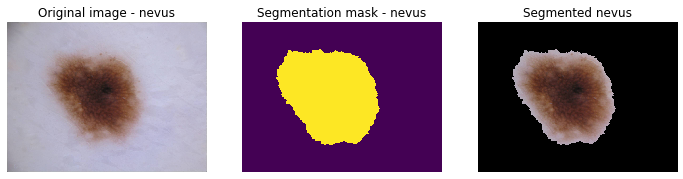

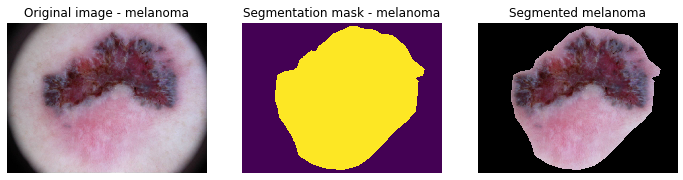

In [0]:
## Plot two examples of nevus and melanoma
print('Two examples of healthy nevus and melanoma')
nevus = imread(Working_directory + 'im/nevus.jpg')
nevus_Segmentation = imread(Working_directory + 'im/nevus-seg.jpg') 
nevus_Segmentation_boolean = (nevus_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
nevus_Segmentation_3D = np.expand_dims(nevus_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
nevus_mul_mask = (nevus_Segmentation_3D*nevus) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(nevus)
grid[0].axis('off')
grid[0].set_title('Original image - nevus')
grid[1].imshow(nevus_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - nevus")
grid[2].imshow(nevus_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented nevus")

###

melanoma = imread(Working_directory + 'im/melanoma.jpg')
melanoma_Segmentation = imread(Working_directory + 'im/melanoma-seg.jpg') 
melanoma_Segmentation_boolean = (melanoma_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
melanoma_Segmentation_3D = np.expand_dims(melanoma_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
melanoma_mul_mask = (melanoma_Segmentation_3D*melanoma) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(melanoma)
grid[0].axis('off')
grid[0].set_title('Original image - melanoma')
grid[1].imshow(melanoma_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - melanoma")
grid[2].imshow(melanoma_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented melanoma")


Now, as in the previous practical session you should shuffle the data randomly

In [0]:
# Shuffle data randomly
import numpy as np
def shuffle(df):
  return df.iloc[np.random.permutation(np.arange(len(df)))]
# Test 
df = pd.DataFrame({ 'A' : range(10), 'B' : range(10)})
print(df)
print(shuffle(df))
#On l'applique au set de données :
Y = pd.DataFrame(X)
XX = shuffle(Y)
print(Y)
print(XX)



   A  B
0  0  0
1  1  1
2  2  2
3  3  3
4  4  4
5  5  5
6  6  6
7  7  7
8  8  8
9  9  9
   A  B
1  1  1
3  3  3
2  2  2
4  4  4
7  7  7
9  9  9
6  6  6
8  8  8
0  0  0
5  5  5
            0          1         2   ...        27        28        29
0    18.183393  35.715288  0.161092  ...  0.523051  0.246898  0.200719
1    26.113225  30.169578  0.170463  ...  0.194775  0.138669  0.131058
2    21.629793  47.411626  0.064632  ...  0.713965  0.735100  0.842481
3    14.753550  49.584792  0.167133  ...  0.360376  0.348889  0.332280
4     6.095158  53.635142  0.174372  ...  0.682795  0.433356  0.376376
..         ...        ...       ...  ...       ...       ...       ...
595  12.587163  26.752263  0.238690  ...  0.433436  0.342468  0.283927
596  16.825556  44.283380  0.166401  ...  0.521805  0.185827  0.174616
597  27.401493  38.219633  0.159420  ...  0.189817  0.177013  0.185952
598  24.095002  25.315394  0.145689  ...  0.229295  0.254076  0.236316
599  15.177158  39.739866  0.093008  ...  0

As we have already seen, it might be very important to scale the data such that each feature has, for instance, average equal to 0 and unit variance.

In [0]:
# Scale data (each feature will have average equal to 0 and unit variance)
mean = np.mean(Y,axis=0)
std  = np.std(Y,axis=0)
n, p = Y.shape
Z = np.zeros((600,30))
Z = pd.DataFrame(Z)
for k in range(p):
  Z[k]=(XX[k]-mean[k])/std[k]
#Show the difference
print(XX)
print(Z)
#Check
print(np.mean(Z,axis=0), np.std(Z,axis=0))

            0          1         2   ...        27        28        29
211  10.949475  51.606185  0.132115  ...  0.439526  0.272042  0.259285
550  20.531891  25.536622  0.091108  ...  0.758704  0.467002  0.411059
107  23.135445  24.705126  0.080206  ...  0.613364  0.520739  0.571280
6    19.854508  22.896372  0.116132  ...  0.351889  0.296605  0.287098
515  17.474327  50.730107  0.155658  ...  0.296409  0.308841  0.274311
..         ...        ...       ...  ...       ...       ...       ...
422  21.981864  42.004293  0.176116  ...  0.312803  0.262844  0.304861
225  27.671255  34.739903  0.212750  ...  0.169770  0.159973  0.177568
548  10.349782  41.345697  0.116015  ...  0.595744  0.392974  0.366350
593  27.353012  29.818294  0.117877  ...  0.291062  0.192030  0.205620
144  10.111684  19.435051  0.139339  ...  0.419448  0.162147  0.197128

[600 rows x 30 columns]
           0         1         2   ...        27        28        29
0   -0.288605 -0.275605  0.086194  ...  0.400711 -0.59

We should now test the discriminative power of our features. Let divide the entire data-set into training and test set and use two simple classification algorithms, a linear and a quadratic one... Look at the confusion matrices and comment the results. 

Normalized confusion matrix
[[0.92121212 0.07878788]
 [0.60606061 0.39393939]]


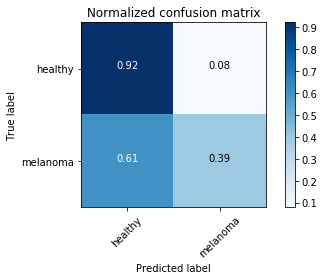

In [0]:
# Create training and test set
Yp = y.copy().ravel()
X_train,X_test,y_train,y_test = train_test_split(Z,y,test_size = 0.33)

# Fitting with the linear one
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)



# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Normalized confusion matrix
[[0.87878788 0.12121212]
 [0.6969697  0.3030303 ]]


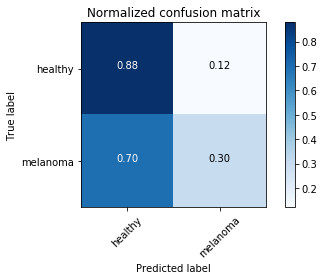

In [0]:
# Fitting with the quadratic one
quad = QuadraticDiscriminantAnalysis()
quad.fit(X_train, y_train)
y_pred = quad.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

The results you obtained are based on a precise subdivision of your data into training and test. This can thus bias your results. Which technique could you use instead ? Test it with at least three different models (e.g. LDA, QDA, K-NN, etc)

**Answer**: We could use the cross validation technique, which is less biased than the simple train/test split. (train/test split gives very different confusion matrices each time we repeat the process)


In [0]:
# Fitting Cross Validation
# Cross-validation for Model Assessment

#NB : I used the sample code you gave in the previous Practical Session

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=Z, y=Yp,cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,X=Z, y=Yp,cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh_score = cross_val_score(neigh,X=Z, y=Yp,cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))


Fitting LDA
done in 0.054s
 Average and std CV score : 0.8033333333333333 +- 0.023921166824012175
Fitting QDA
done in 0.034s
 Average and std CV score : 0.7899999999999999 +- 0.009718253158075509
Fitting K-nearest neighbour
done in 0.094s
 Average and std CV score : 0.7949999999999999 +- 0.02273030282830973


When using K-NN, instead than fixing the number of nearest neighbours, we could also estimate the best value. Do it and plot the confusion matrix. Do you notice anything strange ? 

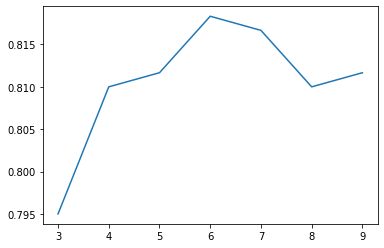

Normalized confusion matrix
[[0.97546012 0.02453988]
 [0.85714286 0.14285714]]


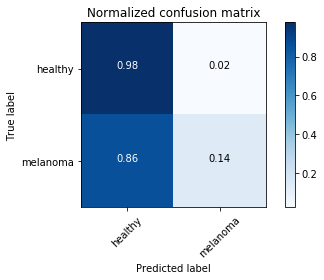

In [0]:
scores = []
for n_neighb in range(3,10):
  neigh = KNeighborsClassifier(n_neighbors= n_neighb)
  neigh_score = cross_val_score(neigh,X=Z, y=Yp,cv=5)
  scores.append(neigh_score.mean())
plt.plot(range(3,10),scores)
plt.show()
#Best value k = 6
# Compute confusion matrix
neigh = KNeighborsClassifier(n_neighbors= 6)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)


# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

I strongly suggest that you look at these two web-pages: 
- https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter, and try other scoring functions with at least one of the 3 previous models.
- https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html and try at least one naive random over-sampling (look at the following code...).

Etrangement, les True Positive sont peu nombreux (0.14 ici). Il est probable que la distribution de classe soit assymétrique. Dans ce cas, il convient d'oversampler pour augmenter la densité de la classe minoritaire.


In [0]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
X_train, X_test, y_train, y_test = train_test_split(Z, Yp, test_size=0.33, random_state=2)
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 322), (1, 322)]


Let's retest KNN on this new data-set. Are the results better ?

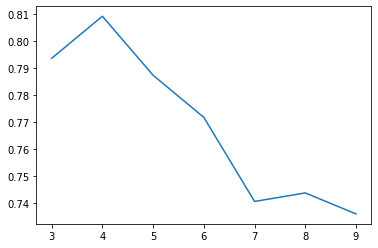

Normalized confusion matrix
[[0.76687117 0.23312883]
 [0.51428571 0.48571429]]


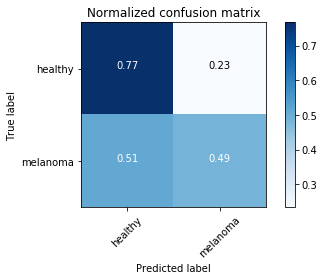

In [0]:
##
scores = []
for n_neighb in range(3,10):
  neigh = KNeighborsClassifier(n_neighbors= n_neighb)
  neigh_score = cross_val_score(neigh,X=X_resampled, y=y_resampled,cv=5)
  scores.append(neigh_score.mean())
plt.plot(range(3,10),scores)
plt.show()
#Meilleure valeur pour  k = 4
neigh = KNeighborsClassifier(n_neighbors= 4)
neigh.fit(X_resampled, y_resampled)
y_pred = neigh.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


Les résultats sont bien meilleurs


Let's use more advanced techiques such as SVM

In [0]:
# Fitting Linear SVM on original data
print("Fitting Linear SVM to the training set")
t0 = time()
Lsvm = LinearSVC(class_weight='balanced') # class_weight needs to be set as balanced when classes are imabalanced > https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
Lsvm_score = cross_val_score(Lsvm,X=Z, y=Yp,cv=5,scoring='precision')
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

Fitting Linear SVM to the training set
done in 0.325s
 Average and std CV score : 0.8033333333333333 +- 0.023921166824012175


Suppose that there are overlapping classes, we need to set the hyper-parameter C. Use Cross-Validation to find the best C value.

The best C is 6  with an average validation score equal to  0.738858024691358
The test score is 0.7171717171717171
Normalized confusion matrix
[[0.76687117 0.23312883]
 [0.51428571 0.48571429]]


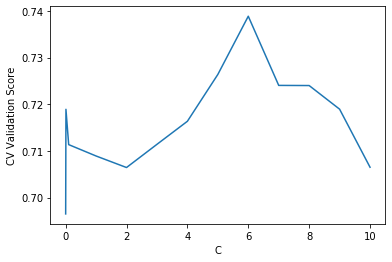

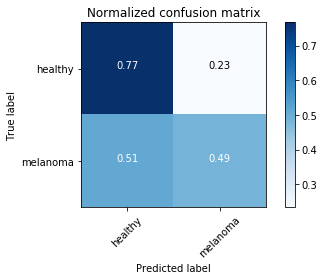

In [0]:
# Looking for the best hyperparameter C 
p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC(class_weight='balanced')
# We only use the training set for finding the best hyper-parameter
grid = GridSearchCV(Lsvm, p_grid_lsvm, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print('The best C is', grid.best_params_.get('C'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1], grid.cv_results_.get('mean_test_score'))
plt.xlabel('C')
plt.ylabel('CV Validation Score')

# Let's now use the best model to assess the test score
BestModel=grid.best_estimator_
print('The test score is', BestModel.score(X_test, y_test))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Try to use the previous SVM code but on the over-sampled data. Does the scoring result change ? 

Le score ne change pas car le SVM n'est pas affecté par l'assymétrie de la distribution.

In [0]:
# Fitting Linear SVM on over-sampled data
t0 = time()
Lsvm = LinearSVC(class_weight='balanced') # class_weight needs to be set as balanced when classes are imabalanced > https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
Lsvm_score = cross_val_score(Lsvm,X=X_resampled, y=y_resampled,cv=5,scoring='precision')
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

done in 0.313s
 Average and std CV score : 0.8033333333333333 +- 0.023921166824012175


Here it is the code for non-linear SVM using radial basis function. We need to tune another hyper-parameter $gamma$. We look for the best $C$ and $gamma$ at the same time.

In [0]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
t0 = time()
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf', class_weight='balanced')
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
# Nested CV with parameter optimization
clf = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, cv=inner_cv)
nested_score = cross_val_score(clf, Z, Yp, cv=outer_cv)
print("done in %0.3fs" % (time() - t0))
print("Average and std Nested Cv score : {0} +- {1}".format(nested_score.mean(), nested_score.std() ))

# Looking for the best hyperparameters
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="precision", cv=5)
grid_nlsvm.fit(X_train, y_train)
print("Best Score: {}".format(grid_nlsvm.best_score_))
print("Best params: {}".format(grid_nlsvm.best_params_))

# NB : il y a quelques erreurs je ne sais pas trop pourquoi


Fitting Non-linear SVM to the training set
done in 33.336s
Average and std Nested Cv score : 0.7983333333333335 +- 0.01699673171197593


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

Best Score: 0.58
Best params: {'C': 2, 'gamma': 0.0001}


Another important point is the importance of the single features.
The more naive technique would be to test each feature independently in a greedy fashion called sequential forward feature selection. Starting from an empty set and a classification model, you will first add the feature that maximizes a certain criterion (i.e. balanced accuracy). Then, you will iterate this process until a chosen stopping criterion by adding at each iteration only the best feature. Each feature can be added of course only once. You could also use the opposite process by removing at each iteraton the least important feature starting from the entire set of features (i.e. sequential backward feature selection). Implement at least one of these ideas. 